In [6]:
# pip install -q scikit-learn litellm


In [1]:
# Import groundedness feedback function
from trulens_eval import Tru
from test_cases import generate_ms_marco_context_relevance_benchmark
from benchmark_frameworks.eval_as_recommendation import score_passages, compute_ndcg, compute_ece, recall_at_k, precision_at_k
Tru().reset_database()

benchmark_data = []
for i in range(1, 6):
    dataset_path = f"./datasets/ms_marco/ms_marco_train_v2.1_{i}.json"
    benchmark_data.extend(list(generate_ms_marco_context_relevance_benchmark(dataset_path)))


🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `Tru` to prevent this.


In [13]:
import os
os.environ["OPENAI_API_KEY"] = "..."
os.environ["HUGGINGFACE_API_KEY"] = "..."
os.environ["ANTHROPIC_API_KEY"] = "..."
os.environ["TOGETHERAI_API_KEY"] = "..."

In [10]:
import pandas as pd
import numpy as np
df = pd.DataFrame(benchmark_data)
df = df.iloc[500:]
print(len(df.groupby("query_id").count()))

255


In [11]:
df.groupby("query_id").head()

,query_id,query,passage,is_selected,relevant_idx
500,512870,temperature to bake sweet potatoes in oven,1 Bake for 45 minutes for sweet potatoes/yams ...,0,2
501,512870,temperature to bake sweet potatoes in oven,1 Turn the oven on to 425. Bake for 45 minute...,0,2
502,512870,temperature to bake sweet potatoes in oven,1 Prick your sweet potatoes each 2-3 time with...,1,2
503,512870,temperature to bake sweet potatoes in oven,1 Don't preheat the oven. Prick your sweet pot...,0,2
504,512870,temperature to bake sweet potatoes in oven,Step 2: Prepare the potatoes for baking by was...,0,2
...,...,...,...,...,...
3032,565901,what are some things you can do to keep your d...,Eating the right foods not only makes it easie...,0,9
3033,565901,what are some things you can do to keep your d...,Eat a healthy diet. Photo Credit Tay Jnr/Digit...,0,9
3034,565901,what are some things you can do to keep your d...,Share. Your digestive system is where it all b...,0,9
3035,565901,what are some things you can do to keep your d...,"Start Slideshow. For some of us, digestive dis...",0,9


#### Define feedback functions for contexnt relevance to be evaluated

In [5]:
from trulens_eval.feedback import OpenAI, LiteLLM
from trulens_eval.feedback.provider.hugs import Huggingface


huggingface_provider = Huggingface()

def wrapped_relevance_truera(input, output):
    return huggingface_provider.context_relevance(input, output)

# GPT 3.5
turbo = OpenAI(model_engine="gpt-3.5-turbo")

def wrapped_relevance_turbo(input, output):
    return turbo.qs_relevance(input, output)

# # GPT 4 turbo
gpt4 = OpenAI(model_engine="gpt-4-1106-preview")

def wrapped_relevance_gpt4(input, output):
    return gpt4.qs_relevance(input, output)


# # Anthropic
# claude_1 = LiteLLM(model_engine="claude-instant-1")
# def wrapped_relevance_claude1(input, output):
#     return claude_1.qs_relevance(input, output)

# claude_2 = LiteLLM(model_engine="claude-2")
# def wrapped_relevance_claude2(input, output):
#     return claude_2.qs_relevance(input, output)


# # # Meta
# llama_2_13b = LiteLLM(model_engine="together_ai/togethercomputer/Llama-2-7B-32K-Instruct")
# def wrapped_relevance_llama2(input, output):
#     return llama_2_13b.qs_relevance(input, output)

# Define a list of your feedback functions
feedback_functions = {
    'GPT-3.5-Turbo': wrapped_relevance_turbo,
    'GPT-4-Turbo': wrapped_relevance_gpt4,
    # 'Claude-1': wrapped_relevance_claude1,
    # 'Claude-2': wrapped_relevance_claude2,
    # 'Llama-2': wrapped_relevance_llama2,
    # 'TruEra': wrapped_relevance_truera,
}

backoffs_by_functions = {
    'GPT-3.5-Turbo': 0.5,
    'GPT-4-Turbo': 0.5,
    # 'Claude-1': 1,
    # 'Claude-2': 1,
    # 'Llama-2': 2,
    # 'TruEra': 2,
}

In [17]:

# Running the benchmark
results = []

K = 5 # for precision@K and recall@K

intermediate_results = []
for name, func in feedback_functions.items():
    try:
        scores, true_relevance = score_passages(df, name, func, backoffs_by_functions[name] if name in backoffs_by_functions else 0.5)
        ndcg_value = compute_ndcg(scores, true_relevance)
        ece_value = compute_ece(scores, true_relevance)
        precision_k = np.mean([precision_at_k(sc, tr, 1) for sc, tr in zip(scores, true_relevance)])
        recall_k = np.mean([recall_at_k(sc, tr, K) for sc, tr in zip(scores, true_relevance)])
        results.append((name, ndcg_value, ece_value, recall_k, precision_k))
        print(f"Finished running feedback function name {name}")
    
        print("Saving results...")
        tmp_results_df = pd.DataFrame(results, columns=['Model', 'nDCG', 'ECE', f'Recall@{K}', 'Precision@1'])
        print(tmp_results_df)
        intermediate_results.append(tmp_results_df)
        
    except Exception as e:
        print(f"Failed to run benchmark for feedback function name {name} due to {e}")
# Convert results to DataFrame for display
results_df = pd.DataFrame(results, columns=['Model', 'nDCG', 'ECE', f'Recall@{K}', 'Precision@1'])


Feedback avg score for query 677 is 0.5, is_selected is 0
Feedback avg score for query 677 is 0.4, is_selected is 0
Feedback avg score for query 677 is 0.9, is_selected is 0
Feedback avg score for query 677 is 1.0, is_selected is 1
Feedback avg score for query 677 is 0.8, is_selected is 0
Feedback avg score for query 677 is 0.7, is_selected is 0
Feedback avg score for query 677 is 0.8, is_selected is 0
Feedback avg score for query 677 is 0.54, is_selected is 0
Feedback avg score for query 677 is 0.2, is_selected is 0
Feedback avg score for query 677 is 0.2, is_selected is 0
Query 677 scored 10 out of 10 passages.
Feedback avg score for query 18268 is 0.2, is_selected is 0
Feedback avg score for query 18268 is 1.0, is_selected is 1
Feedback avg score for query 18268 is 0.8, is_selected is 0
Feedback avg score for query 18268 is 0.2, is_selected is 0
Feedback avg score for query 18268 is 0.8, is_selected is 0
Feedback avg score for query 18268 is 0.7, is_selected is 0
Feedback avg score 

In [23]:
results_df.to_csv("results_gpt.csv")

In [6]:
results_df

NameError: name 'results_df' is not defined

### Visualization

In [12]:
from trulens_eval.feedback import LiteLLM
from trulens_eval.feedback.provider.hugs import Huggingface


huggingface_provider = Huggingface()

# TruEra model
def wrapped_relevance_truera(input, output):
    return huggingface_provider.context_relevance(input, output)

# Meta
llama_2_13b = LiteLLM(model_engine="together_ai/togethercomputer/Llama-2-7B-32K-Instruct")
def wrapped_relevance_llama2(input, output):
    return llama_2_13b.qs_relevance(input, output)

# Define a list of your feedback functions
feedback_functions = {
    # 'Llama-2': wrapped_relevance_llama2,
    'TruEra': wrapped_relevance_truera,
}

backoffs_by_functions = {
    'Llama-2': 2.5,
    'TruEra': 2.5,
}

# Running the benchmark
results = []

K = 5 # for precision@K 
intermediate_results = []
for name, func in feedback_functions.items():
    try:
        scores, true_relevance = score_passages(df, name, func, backoffs_by_functions[name] if name in backoffs_by_functions else 0.5)
        ndcg_value = compute_ndcg(scores, true_relevance)
        ece_value = compute_ece(scores, true_relevance)
        precision_k = np.mean([precision_at_k(sc, tr, 1) for sc, tr in zip(scores, true_relevance)])
        recall_k = np.mean([recall_at_k(sc, tr, K) for sc, tr in zip(scores, true_relevance)])
        results.append((name, ndcg_value, ece_value, recall_k, precision_k))
        print(f"Finished running feedback function name {name}")
    
        print("Saving results...")
        tmp_results_df = pd.DataFrame(results, columns=['Model', 'nDCG', 'ECE', f'Recall@{K}', 'Precision@1'])
        print(tmp_results_df)
        intermediate_results.append(tmp_results_df)
        
    except Exception as e:
        print(f"Failed to run benchmark for feedback function name {name} due to {e}")
# Convert results to DataFrame for display
results_df_tru = pd.DataFrame(results, columns=['Model', 'nDCG', 'ECE', f'Recall@{K}', 'Precision@1'])


Feedback avg score for query 677 is 0.7705180644989014, is_selected is 0
Feedback avg score for query 677 is 0.5913048386573792, is_selected is 0
Feedback avg score for query 677 is 0.060428548604249954, is_selected is 0
Feedback avg score for query 677 is 0.12427417188882828, is_selected is 1
Feedback avg score for query 677 is 0.5233588814735413, is_selected is 0
Feedback avg score for query 677 is 0.6502860188484192, is_selected is 0
Feedback avg score for query 677 is 0.2014804482460022, is_selected is 0
Feedback avg score for query 677 is 0.11623057723045349, is_selected is 0
Feedback avg score for query 677 is 0.699424684047699, is_selected is 0
Feedback avg score for query 677 is 0.40093597769737244, is_selected is 0
Query 677 scored 10 out of 10 passages.
Feedback avg score for query 18268 is 0.07255132496356964, is_selected is 0
Feedback avg score for query 18268 is 0.6755996346473694, is_selected is 1
Feedback avg score for query 18268 is 0.10550739616155624, is_selected is 0

Waiting for {'error': 'Model truera/context_relevance is currently loading', 'estimated_time': 20.0} (20.0) second(s).


Feedback avg score for query 45605 is 0.03424430638551712, is_selected is 0
Query 45605 scored 10 out of 10 passages.
Feedback avg score for query 47416 is 0.040804337710142136, is_selected is 0
Feedback avg score for query 47416 is 0.598534882068634, is_selected is 1
Feedback avg score for query 47416 is 0.05547226220369339, is_selected is 0
Feedback avg score for query 47416 is 0.25783467292785645, is_selected is 0
Feedback avg score for query 47416 is 0.248014435172081, is_selected is 0
Feedback avg score for query 47416 is 0.15463227033615112, is_selected is 0
Feedback avg score for query 47416 is 0.731151282787323, is_selected is 0
Feedback avg score for query 47416 is 0.39481502771377563, is_selected is 0
Feedback avg score for query 47416 is 0.14820177853107452, is_selected is 0
Feedback avg score for query 47416 is 0.35770145058631897, is_selected is 0
Query 47416 scored 10 out of 10 passages.
Feedback avg score for query 50251 is 0.7859541177749634, is_selected is 1
Feedback a

Waiting for {'error': 'Model truera/context_relevance is currently loading', 'estimated_time': 20.0} (20.0) second(s).


Feedback avg score for query 187620 is 0.4922339618206024, is_selected is 0
Query 187620 scored 10 out of 10 passages.
Feedback avg score for query 189335 is 0.24175237119197845, is_selected is 0
Feedback avg score for query 189335 is 0.08382987976074219, is_selected is 0
Feedback avg score for query 189335 is 0.07784411311149597, is_selected is 0
Feedback avg score for query 189335 is 0.1534198373556137, is_selected is 0
Feedback avg score for query 189335 is 0.12620922923088074, is_selected is 1
Feedback avg score for query 189335 is 0.14835260808467865, is_selected is 0
Feedback avg score for query 189335 is 0.40877917408943176, is_selected is 0
Feedback avg score for query 189335 is 0.04304444044828415, is_selected is 0
Feedback avg score for query 189335 is 0.015493913553655148, is_selected is 0
Feedback avg score for query 189335 is 0.053983815014362335, is_selected is 0
Query 189335 scored 10 out of 10 passages.
Feedback avg score for query 190014 is 0.18221788108348846, is_sele

API error: {'error': 'Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate'}.


Failed to run benchmark for feedback function name TruEra due to Rate limit reached. You reached free usage limit (reset hourly). Please subscribe to a plan at https://huggingface.co/pricing to use the API at this rate


In [8]:
intermediate_results

[]

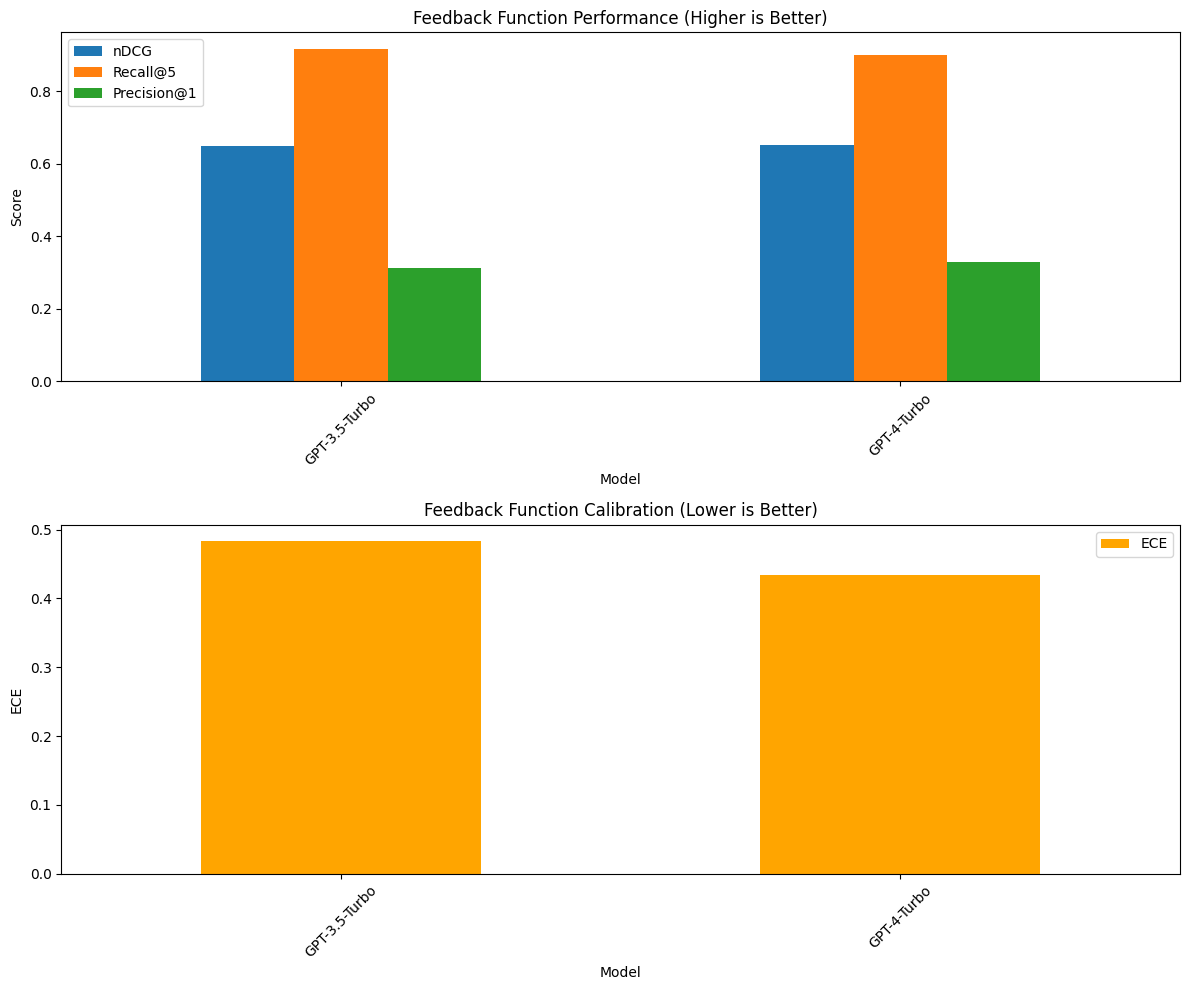

In [21]:

import matplotlib.pyplot as plt


# Make sure results_df is defined and contains the necessary columns
# Also, ensure that K is defined

plt.figure(figsize=(12, 10))

# Graph for nDCG, Recall@K, and Precision@K
plt.subplot(2, 1, 1)  # First subplot
ax1 = results_df.plot(x='Model', y=['nDCG', f'Recall@{K}', 'Precision@1'], kind='bar', ax=plt.gca())
plt.title('Feedback Function Performance (Higher is Better)')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='upper left')

# Graph for ECE
plt.subplot(2, 1, 2)  # Second subplot
ax2 = results_df.plot(x='Model', y=['ECE'], kind='bar', ax=plt.gca(), color='orange')
plt.title('Feedback Function Calibration (Lower is Better)')
plt.ylabel('ECE')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


